In [31]:
import os
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model

In [32]:
# Define data_path and data
data_path = 'Af-Mitdb/'
data = ['100','101','102','103','104','105','106','107',
        '108','109','111','112','113','114','115','116',
        '117','118','119','121','122','123','124','200',
        '201','202','203','205','207','208','209','210',
        '212','213','214','215','217','219','220','221',
        '222','223','228','230','231','232','233','234',
        '04015', '04043', '04048', '04126', '04746',
        '04908', '04936', '05091', '05121', '05261',
        '06426', '06453', '06995', '07162', '07859',
        '07879', '07910', '08215', '08219', '08378',
        '08405', '08434', '08455']


In [33]:
def load_preprocess_data(data_path, record_name):
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:, 0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Standardize the signal
    scaler = StandardScaler()
    ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

    # Pad or truncate signal to a fixed length
    target_length = 1000  # You can adjust this length as needed
    if len(ecg_signal) < target_length:
        pad_length = target_length - len(ecg_signal)
        ecg_signal = np.pad(ecg_signal, (0, pad_length), 'constant')
    elif len(ecg_signal) > target_length:
        ecg_signal = ecg_signal[:target_length]

    return ecg_signal


In [34]:
all_ecg_data = []

for record_name in data:
    ecg_data = load_preprocess_data(data_path, record_name)
    all_ecg_data.append(ecg_data)

all_ecg_data = np.array(all_ecg_data)


In [35]:
target_length = 1000
input_layer = Input(shape=(target_length, 1))


In [46]:
# Encoder
encoded = LSTM(32, activation='relu', return_sequences=False)(input_layer)
encoded = RepeatVector(target_length)(encoded)

# Decoder
decoded = LSTM(32, activation='relu', return_sequences=True)(encoded)
decoded_output = LSTM(1, activation='linear', return_sequences=True)(decoded)

# Create the LSTM Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training on all records with early stopping
history = autoencoder.fit(all_ecg_data.reshape(-1, target_length, 1),
                          all_ecg_data.reshape(-1, target_length, 1),
                          epochs=num_epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

Epoch 1/100
2/2 [==============================] - 5s 1s/step - loss: 0.8282 - val_loss: 0.9001
Epoch 2/100
2/2 [==============================] - 2s 819ms/step - loss: 0.8240 - val_loss: 0.8938
Epoch 3/100
2/2 [==============================] - 2s 820ms/step - loss: 0.8209 - val_loss: 0.8873
Epoch 4/100
2/2 [==============================] - 2s 838ms/step - loss: 0.8177 - val_loss: 0.8802
Epoch 5/100
2/2 [==============================] - 2s 801ms/step - loss: 0.8144 - val_loss: 0.8722
Epoch 6/100
2/2 [==============================] - 2s 804ms/step - loss: 0.8120 - val_loss: 0.8637
Epoch 7/100
2/2 [==============================] - 2s 807ms/step - loss: 0.8097 - val_loss: 0.8556
Epoch 8/100
2/2 [==============================] - 2s 826ms/step - loss: 0.8095 - val_loss: 0.8495
Epoch 9/100
2/2 [==============================] - 2s 837ms/step - loss: 0.8108 - val_loss: 0.8454
Epoch 10/100
2/2 [==============================] - 2s 817ms/step - loss: 0.8102 - val_loss: 0.8461
Epoch 11/100

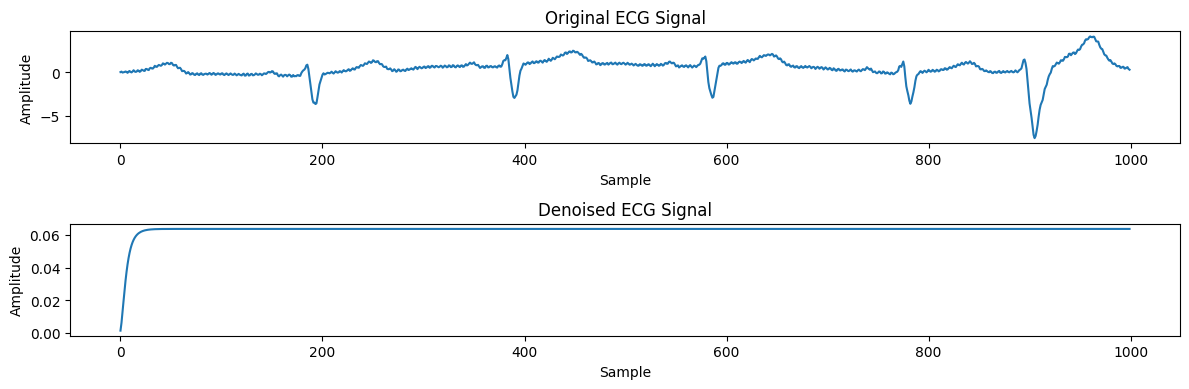

In [49]:
# Plot the original and denoised signal
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(ecg_data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original ECG Signal')

plt.subplot(2, 1, 2)
plt.plot(denoised_data.flatten())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Denoised ECG Signal')
plt.tight_layout()
plt.show()

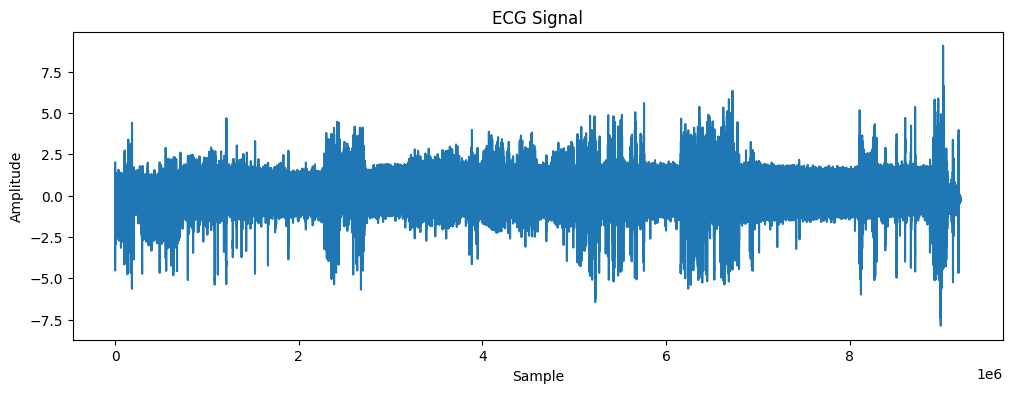

In [51]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [52]:
symbols_df

,symbol,Counts,data Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,79,08219
0,+,17,08378
0,+,4,08405
0,+,7,08434


In [53]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1896
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [54]:
# Normal Beat Symbols
normal = ['N']

# Abnormal Beat Symbols
AF = ['f']
PAC = ['A']
PVC = ['V']

abnormal_category = AF + PAC + PVC + normal

# Classifying abnormal beats into more specific categories
symbols_df.loc[symbols_df.symbol == 'N','abnormal_category'] = "N"
symbols_df.loc[symbols_df.symbol.isin(AF), 'abnormal_category'] = "AF"
symbols_df.loc[symbols_df.symbol.isin(PAC), 'abnormal_category'] = "PAC"
symbols_df.loc[symbols_df.symbol.isin(PVC), 'abnormal_category'] = "PVC"

# Value counts of different categories
symbols_df.groupby('abnormal_category').Counts.sum()

abnormal_category
AF       982
N      75052
PAC     2546
PVC     7130
Name: Counts, dtype: int64

In [55]:
def load_ecg(file):
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')

    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample


In [56]:
# Accessing the ecg points for
file = data_path + data[8]

In [57]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [58]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 4


In [59]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal_category][:10]
ab_index

[88, 442, 789, 1155, 1493, 1821, 2157, 2517, 2889, 3238]

In [60]:
def make_dataset(record_patients, num_sec, fs, abnormal_category):

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,len(abnormal_category)))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in data:
        file = data_path + pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal_category)]

        num_rows = len(df_ann)

        X = np.zeros((num_rows, num_cols))
        Y = np.zeros((num_rows, len(abnormal_category)))
        sym = []

        # keep track of rows
        max_row = 0

        for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

            left = max([0,(atr_sample - num_sec*fs) ])
            right = min([len(p_signal),(atr_sample + num_sec*fs) ])
            x = p_signal[left: right]
            if len(x) == num_cols:
                X[max_row,:] = x
                Y[max_row, abnormal_category.index(atr_sym)] = 1
                sym.append(atr_sym)
                max_row += 1
        X = X[:max_row,:]
        Y = Y[:max_row,:]

        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)

    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


  abnormal_category  Counts
0                AF     982
1                 N   75052
2               PAC    2546
3               PVC    7130


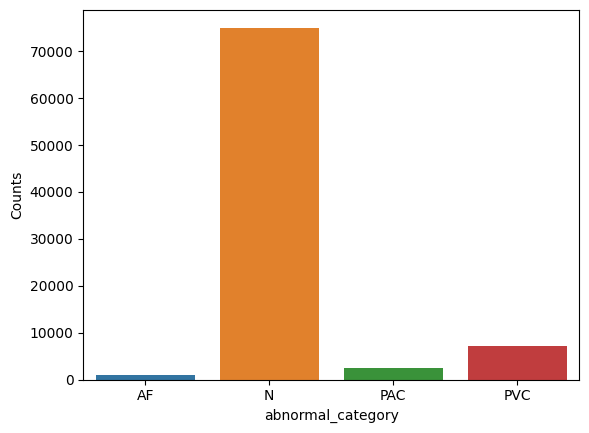

In [61]:
import seaborn as sns
# Value counts of different categories
counts_df = symbols_df.groupby('abnormal_category')['Counts'].sum().reset_index()
print(counts_df)

# Visualize the number of subjects in each abnormal_category:
sns.barplot(x='abnormal_category', y='Counts', data=counts_df)
plt.show()


In [62]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.fft import fft

def extract_features(rr_intervals):
    features = {}

    # RR Interval Features
    rr_mean = np.mean(rr_intervals)
    rr_std = np.std(rr_intervals)
    rr_min = np.min(rr_intervals)
    rr_max = np.max(rr_intervals)
    rr_range = rr_max - rr_min
    rr_median = np.median(rr_intervals)
    rr_diff = np.diff(rr_intervals)
    rr_fft = np.abs(fft(rr_intervals))
    rr_skewness = skew(rr_intervals)
    rr_kurtosis = kurtosis(rr_intervals)

    features['RR Mean'] = rr_mean
    features['RR Std'] = rr_std
    features['RR Min'] = rr_min
    features['RR Max'] = rr_max
    features['RR Range'] = rr_range
    features['RR Median'] = rr_median
    features['RR Skewness'] = rr_skewness
    features['RR Kurtosis'] = rr_kurtosis

    features['mean_rr_diff'] = np.mean(rr_diff)
    features['std_rr_diff'] = np.std(rr_diff)
    features['min_rr_diff'] = np.min(rr_diff)
    features['max_rr_diff'] = np.max(rr_diff)
    features['median_rr_diff'] = np.median(rr_diff)
    features['range_rr_diff'] = np.ptp(rr_diff)

    features['RR FFT Mean'] = np.mean(rr_fft)
    features['RR FFT Std'] = np.std(rr_fft)
    features['RR FFT Max'] = np.max(rr_fft)

    rr_variance = np.var(rr_intervals)
    rr_coefficient_of_variation = np.mean(rr_intervals) / np.std(rr_intervals)

    features['RR Variance'] = rr_variance
    features['RR Coefficient of Variation'] = rr_coefficient_of_variation

    # Additional Statistical Features
    features['RR 5th Percentile'] = np.percentile(rr_intervals, 5)
    features['RR 95th Percentile'] = np.percentile(rr_intervals, 95)
    features['RR Interquartile Range'] = np.percentile(rr_intervals, 75) - np.percentile(rr_intervals, 25)

    # Additional Dynamic Features
    rr_diff_mean = np.mean(rr_diff)
    rr_diff_std = np.std(rr_diff)
    rr_diff_min = np.min(rr_diff)
    rr_diff_max = np.max(rr_diff)
    rr_diff_median = np.median(rr_diff)
    rr_diff_range = np.ptp(rr_diff)

    features['mean_rr_diff'] = rr_diff_mean
    features['std_rr_diff'] = rr_diff_std
    features['min_rr_diff'] = rr_diff_min
    features['max_rr_diff'] = rr_diff_max
    features['median_rr_diff'] = rr_diff_median
    features['range_rr_diff'] = rr_diff_range


    return features

In [63]:
import matplotlib.pyplot as plt

# Set the parameters
num_sec = 3
fs = 360

# Accessing the function and creating a dataset with ECG digital points
X_all, Y_all, sym_all = make_dataset(data, num_sec, fs, abnormal_category)

# Mengambil segmen RR interval
rr_intervals = X_all[:, fs * num_sec:]

features = []
for rr in rr_intervals:
    feature = extract_features(rr)
    features.append(feature)

# Convert the features list to a dataframe
df_features = pd.DataFrame(features)

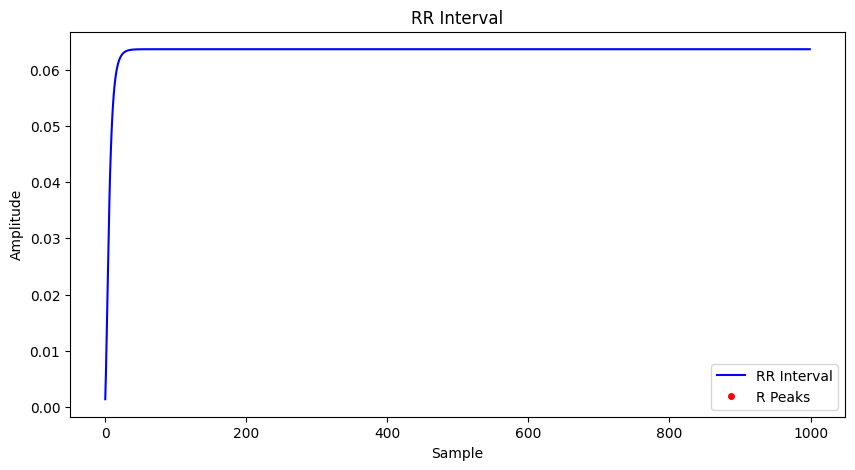

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming denoised_data is a 2D array or list of lists, convert it to 1-D
denoised_data = np.array(denoised_data).flatten()

r_peaks, _ = find_peaks(denoised_data[:len(rr_intervals[0])], prominence=0.4)

# Plot the QRS complexes with R, Q, and S peaks
plt.figure(figsize=(10, 5))
plt.plot(denoised_data[:len(rr_intervals[0])], color='blue', label='RR Interval')
plt.plot(r_peaks, denoised_data[r_peaks], 'ro', markersize=4, label='R Peaks')

plt.title('RR Interval')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [68]:
import numpy as np
from keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.optimizers import RMSprop

# Jumlah lipatan pada K-Fold
num_folds = 5

# Inisialisasi array untuk menyimpan hasil evaluasi
accuracies = []
conf_matrices = []

# Inisialisasi K-Fold Cross Validation
kfold = KFold(n_splits=num_folds, shuffle=True)

for train_index, test_index in kfold.split(df_features):
    X_train, X_val = df_features.iloc[train_index[:-50]], df_features.iloc[train_index[-50:]]
    Y_train, Y_val = Y_all[train_index[:-50]], Y_all[train_index[-50:]]
    X_test, Y_test = df_features.iloc[test_index], Y_all[test_index]

    # Standarisasi fitur input
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Reshape fitur input untuk LSTM
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

    # Build the LSTM model for multi-label classification
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    # Menentukan EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Mengompilasi dan melatih model
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    model.fit(X_train_reshaped, Y_train, epochs=100, batch_size=128, validation_data=(X_val_reshaped, Y_val), callbacks=[early_stopping])

    # Evaluasi model pada data pengujian
    loss, accuracy = model.evaluate(X_test_reshaped, Y_test)
    accuracies.append(accuracy)

    # Prediksi kelas pada data pengujian
    Y_pred = model.predict(X_test_reshaped)
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_test, axis=1)

    # Matriks konfusi
    conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels, labels=np.arange(len(abnormal_category)))
    conf_matrices.append(conf_matrix)

# Rata-rata akurasi dan matriks konfusi pada semua lipatan
mean_accuracy = np.mean(accuracies)
mean_conf_matrix = np.sum(conf_matrices, axis=0)

print("Mean Accuracy:", mean_accuracy)
print("Mean Confusion Matrix:")
print(mean_conf_matrix)

# Classification report
print("Classification Report:")
print(classification_report(Y_true_labels, Y_pred_labels, labels=np.arange(len(abnormal_category)), target_names=abnormal_category))

# Menghitung sensitivity untuk setiap kelas abnormal
sensitivities = []
for i in range(len(abnormal_category)):
    true_positives = mean_conf_matrix[i, i]
    false_negatives = np.sum(mean_conf_matrix[i, :]) - true_positives
    sensitivity = true_positives / (true_positives + false_negatives)
    sensitivities.append(sensitivity)

# Menampilkan sensitivities
for i in range(len(abnormal_category)):
    print(f"Sensitivity ({abnormal_category[i]}): {sensitivities[i]}")

print('')

sensitivities = []
for conf_matrix in conf_matrices:
    tp = conf_matrix[1, 1]  # True positives
    fn = conf_matrix[1, 0]  # False negatives
    sensitivity = tp / (tp + fn)
    sensitivities.append(sensitivity)

mean_sensitivity = np.mean(sensitivities)
print("Mean Sensitivity:", mean_sensitivity)

print('')
print('==================================================================')
print('')

# Menghitung specificities untuk setiap kelas abnormal
specificities = []
for i in range(len(abnormal_category)):
    true_negatives = np.sum(mean_conf_matrix) - np.sum(mean_conf_matrix[i, :]) - np.sum(mean_conf_matrix[:, i]) + mean_conf_matrix[i, i]
    false_positives = np.sum(mean_conf_matrix[:, i]) - mean_conf_matrix[i, i]
    specificity = true_negatives / (true_negatives + false_positives)
    specificities.append(specificity)

# Menampilkan specificities
for i in range(len(abnormal_category)):
    print(f"Specificity ({abnormal_category[i]}): {specificities[i]}")

print('')

specificities = []
for conf_matrix in conf_matrices:
    tn = conf_matrix[0, 0]  # True negatives
    fp = conf_matrix[0, 1]  # False positives
    specificity = tn / (tn + fp)
    specificities.append(specificity)

mean_specificity = np.mean(specificities)
print("Mean Specificity:", mean_specificity)

Epoch 1/100
534/534 [==============================] - 64s 111ms/step - loss: 0.4489 - accuracy: 0.8758 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 2/100
534/534 [==============================] - 95s 179ms/step - loss: 0.3630 - accuracy: 0.8911 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 3/100
534/534 [==============================] - 81s 151ms/step - loss: 0.3196 - accuracy: 0.9011 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 4/100
534/534 [==============================] - 94s 176ms/step - loss: 0.2880 - accuracy: 0.9064 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 5/100
534/534 [==============================] - 86s 161ms/step - loss: 0.2633 - accuracy: 0.9119 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 6/100
534/534 [==============================] - 97s 181ms/step - loss: 0.2440 - accuracy: 0.9166 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 7/100
534/534 [==============================] - 85s 160ms/step - loss: 0.2314 - accuracy: 0.9217 - val_loss: 0.0030 -